In [ ]:
import torch
import os
import tqdm

import sys
sys.path.append("..")
from utils.checkpoint import save_ckpt_template as save_ckpt, load_ckpt_template as load_ckpt

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True   # 加速卷积计算
else:
    device = torch.device('cpu')

print(device)

In [ ]:
from data.septimbre import Instruments
dataset = Instruments(
    folder = '../data/multi_large_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=18, shuffle=True, pin_memory=True, num_workers=4)
print("训练集大小: ", len(dataset))
input, label = dataset[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

val = Instruments(
    folder = '../data/multi_medium_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
valloader = torch.utils.data.DataLoader(val, batch_size=18, shuffle=False, pin_memory=True, num_workers=4)
print("测试集大小: ", len(val))
input, label = val[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

# CQT配置
import tomllib
with open('../model/config.toml', 'br') as f:
    CQTconfig = tomllib.load(f)['CQT']
s_per_frame = CQTconfig['hop'] / CQTconfig['fs']

_model = None

In [ ]:
# 从分体开始
from basicamt import BasicAMT, BasicAMT_all
_model = BasicAMT().to(device)
optimizer = torch.optim.AdamW(_model.parameters(), lr=2e-4)
checkpoint_path = "basicamt.pth"

# 加载最佳模型
states = load_ckpt(_model, optimizer, "best_" + checkpoint_path)
if not states:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt.pth'
epoch: 46, loss: 799.6741782531737, min_loss: 819.2056848602294


In [ ]:
from basicamt import BasicAMT, BasicAMT_all
if _model is not None:
    model = BasicAMT_all(CQTconfig, _model.state_dict()).to(device)
    print("model initialized from BasicAMT")
else:
    model = BasicAMT_all(CQTconfig).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, threshold=1e-3)
checkpoint_path = "basicamt_all.pth"
loss_path = "basicamt_all.loss.txt"
min_loss = float('inf')
epoch_now = 0

In [ ]:
# 加载上一轮模型参数
states = load_ckpt(model, optimizer, checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No checkpoint loaded. Training from scratch.")

Checkpoint loaded from 'basicamt_all.pth'
epoch: 59, loss: 3293.635726342139, min_loss: 3288.4482824845745


In [ ]:
epoch_total = 60
stage_save_interval = 40    # save checkpoint every $stage_save_interval$ epochs

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)    # input: (batch, mix, 2, time)
        target = target.to(device)  # target: (batch, mix, 7 * 12, 660)

        # 由于basicamt的目标没有分离音色，因此mix仅仅是数据增强的手段
        if dataset.mix > 1:
            mixed = torch.mean(input, dim=1, keepdim=False)  # 混合后的CQT
            midi_mixed, _ = target.max(dim=-3, keepdim=False)
        else:
            mixed = input.squeeze(dim=1)
            midi_mixed = target.squeeze(dim=1)

        mixed = mixed + torch.randn_like(mixed) * 0.007   # 加入噪声 经过听觉和可视化觉得0.007是一个合适的值
        # midi_mixed: (batch, 7 * 12, 660)

        onset, note = model(mixed)
        # onset & note: (batch, 7 * 12, 660)
        loss = BasicAMT.loss(onset, note, midi_mixed)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            if val.mix > 1:
                mixed = torch.sum(input, dim=1, keepdim=False)
                midi_mixed, _ = target.max(dim=-3, keepdim=False)
            else:
                mixed = input.squeeze(dim=1)
                midi_mixed = target.squeeze(dim=1)

            onset, note = model(mixed)
            loss = BasicAMT.loss(onset, note, midi_mixed)
            val_loss += loss.item()

        val_loss /= len(valloader)
    
    final_loss = val_loss * 0.85 + train_loss * 0.15
    schedular.step(final_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_ckpt(epoch, model, min_loss, final_loss, optimizer, checkpoint_filename)
    if final_loss < min_loss:
        min_loss = final_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch

100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


====> Epoch: 6 Average train loss: 3917.3887; Average val loss: 4094.8197


100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


====> Epoch: 7 Average train loss: 3840.7404; Average val loss: 3879.3502


100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


====> Epoch: 8 Average train loss: 3777.8338; Average val loss: 4372.8685


100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


====> Epoch: 9 Average train loss: 3726.1609; Average val loss: 3942.4003


100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


====> Epoch: 10 Average train loss: 3677.3721; Average val loss: 3797.8556


100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


====> Epoch: 11 Average train loss: 3640.1839; Average val loss: 3870.3552


100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


====> Epoch: 12 Average train loss: 3604.5461; Average val loss: 3742.7561


100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


====> Epoch: 13 Average train loss: 3570.7518; Average val loss: 3831.2627


100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


====> Epoch: 14 Average train loss: 3528.7589; Average val loss: 3815.5495


100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


====> Epoch: 15 Average train loss: 3511.6494; Average val loss: 3646.4676


100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


====> Epoch: 16 Average train loss: 3483.8895; Average val loss: 3571.2679


100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


====> Epoch: 17 Average train loss: 3452.8283; Average val loss: 3571.4688


100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


====> Epoch: 18 Average train loss: 3434.5381; Average val loss: 3641.5670


100%|██████████| 40/40 [00:14<00:00,  2.71it/s]


====> Epoch: 19 Average train loss: 3415.8292; Average val loss: 3564.0010


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


====> Epoch: 20 Average train loss: 3390.1093; Average val loss: 3478.1205


100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


====> Epoch: 21 Average train loss: 3375.3524; Average val loss: 3649.9748


100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


====> Epoch: 22 Average train loss: 3365.8869; Average val loss: 3502.4394


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 23 Average train loss: 3332.0000; Average val loss: 3652.2610


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 24 Average train loss: 3257.4483; Average val loss: 3383.8471


100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


====> Epoch: 25 Average train loss: 3248.2800; Average val loss: 3392.9531


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 26 Average train loss: 3238.9913; Average val loss: 3383.0918


100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


====> Epoch: 27 Average train loss: 3233.0969; Average val loss: 3358.0371


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 28 Average train loss: 3230.4106; Average val loss: 3356.1239


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 29 Average train loss: 3226.1052; Average val loss: 3361.0382


100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


====> Epoch: 30 Average train loss: 3216.2143; Average val loss: 3366.6825


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 31 Average train loss: 3189.3209; Average val loss: 3329.7009


100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


====> Epoch: 32 Average train loss: 3187.1189; Average val loss: 3326.1911


100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


====> Epoch: 33 Average train loss: 3182.0757; Average val loss: 3332.3439


100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


====> Epoch: 34 Average train loss: 3184.8336; Average val loss: 3320.2057


100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


====> Epoch: 35 Average train loss: 3179.3006; Average val loss: 3329.2394


100%|██████████| 40/40 [00:13<00:00,  3.08it/s]


====> Epoch: 36 Average train loss: 3179.4614; Average val loss: 3322.2919


100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


====> Epoch: 37 Average train loss: 3175.4201; Average val loss: 3330.9786


100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


====> Epoch: 38 Average train loss: 3167.3255; Average val loss: 3319.2523


100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


====> Epoch: 39 Average train loss: 3163.7895; Average val loss: 3320.1538


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 40 Average train loss: 3165.6625; Average val loss: 3318.0032


100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


====> Epoch: 41 Average train loss: 3163.3390; Average val loss: 3324.1279


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 42 Average train loss: 3162.2287; Average val loss: 3314.9831


100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


====> Epoch: 43 Average train loss: 3160.0523; Average val loss: 3321.1194


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 44 Average train loss: 3159.7115; Average val loss: 3315.3337


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 45 Average train loss: 3160.3599; Average val loss: 3311.0521


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 46 Average train loss: 3160.7147; Average val loss: 3313.9551


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 47 Average train loss: 3161.1145; Average val loss: 3311.7960


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 48 Average train loss: 3161.4219; Average val loss: 3322.6081


100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


====> Epoch: 49 Average train loss: 3159.2320; Average val loss: 3317.5423


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 50 Average train loss: 3159.3829; Average val loss: 3316.3754


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 51 Average train loss: 3160.3102; Average val loss: 3311.8495


100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


====> Epoch: 52 Average train loss: 3158.9694; Average val loss: 3314.4813


100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


====> Epoch: 53 Average train loss: 3155.9817; Average val loss: 3315.5394


100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


====> Epoch: 54 Average train loss: 3157.8092; Average val loss: 3314.1241


100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


====> Epoch: 55 Average train loss: 3159.3458; Average val loss: 3314.8541


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 56 Average train loss: 3159.7018; Average val loss: 3315.8668


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


====> Epoch: 57 Average train loss: 3157.7376; Average val loss: 3314.6191


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


====> Epoch: 58 Average train loss: 3157.2773; Average val loss: 3314.2621


100%|██████████| 40/40 [00:12<00:00,  3.14it/s]

====> Epoch: 59 Average train loss: 3156.5801; Average val loss: 3317.8220


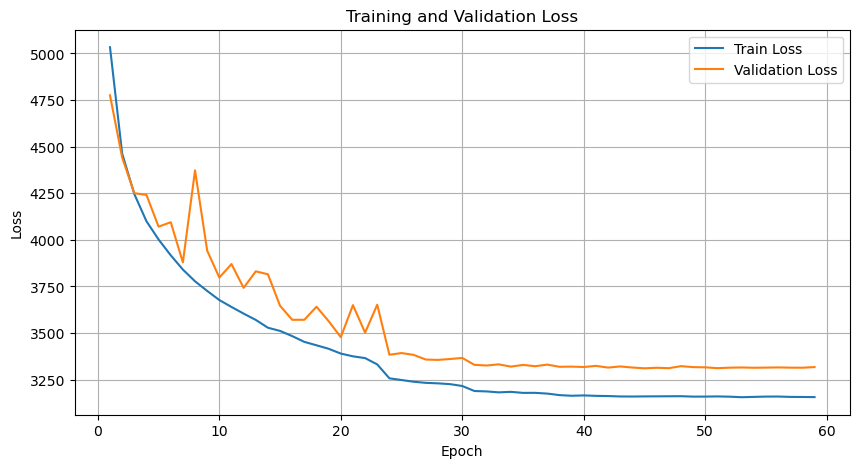

In [ ]:
# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

epochs = []
train_losses = []
val_losses = []

with open(loss_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        epoch = int(parts[0].split(':')[0])
        train_loss = float(parts[1].split(': ')[1])
        val_loss = float(parts[2].split(': ')[1])
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 测试模型

In [ ]:
# 加载最佳模型
states = load_ckpt(model, optimizer, "best_" + checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt_all.pth'
epoch: 45, loss: 3288.4482824845745, min_loss: 3291.9903567148185


In [ ]:
# 切换到cpu 因为benchmark会导致初次运行时间长
device = torch.device('cpu')
model = model.to(device)
torch.backends.cudnn.benchmark = False

In [ ]:
# 读取音频
import torchaudio
from utils.midiarray import midi2numpy
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np

test_wave_path = "../data/inferMusic/piano_short.wav"
waveInfo(test_wave_path)

waveform, sample_rate = torchaudio.load(test_wave_path, normalize=True)
waveform = waveform.unsqueeze(0)
print(waveform.shape)

test_midi_path = test_wave_path.replace('.wav', '.mid')
s_per_frame = 256 / 22050
midi_array = midi2numpy(test_midi_path, s_per_frame)
plt.figure(figsize=(12, 6))
plt.imshow(midi_array, aspect='auto', origin='lower', cmap='gray')
plt.colorbar()
plt.title('MIDI Array')
plt.xlabel('Time Frames')
plt.ylabel('MIDI Notes')
plt.show()
print(midi_array.shape)

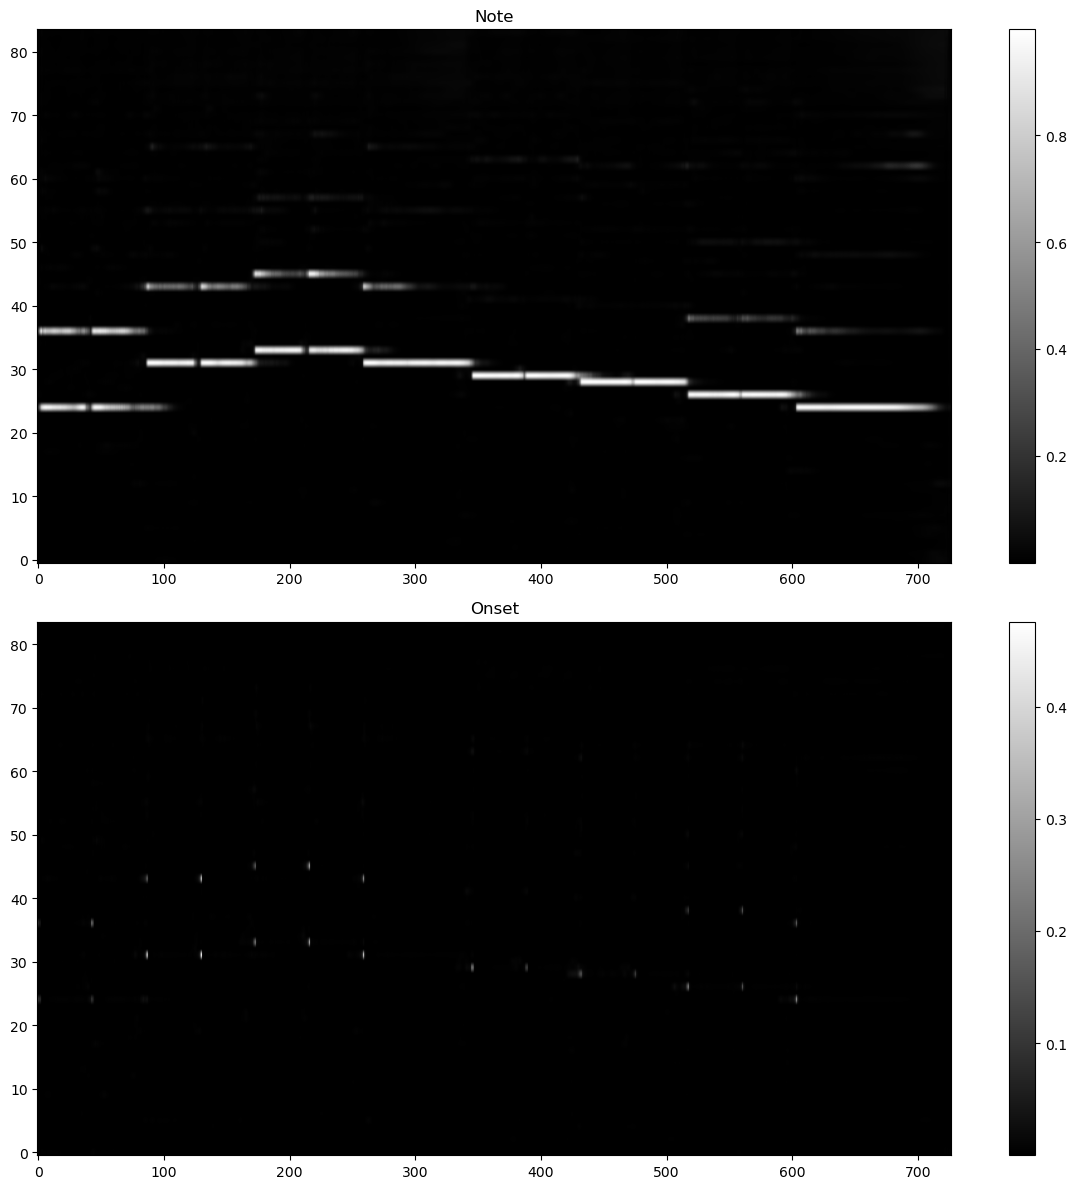

In [ ]:
model.eval()
with torch.no_grad():
    onset, note = model(waveform)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 1, 1)
    plt.title('Note')
    plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.title('Onset')
    plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [ ]:
torch.save(model, "basicamt_model.pth")